In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2023-09-28 14:39:05.959804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 14:39:06.612244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick/miniconda3/envs/tf_env/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/nick/miniconda3/envs/tf_env/lib/
2023-09-28 14:39:06.612354: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        print(y)
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train[0]

array([[ 0.4596948 ],
       [ 0.31486678],
       [ 0.12497123],
       [-0.1039134 ],
       [-0.33817387],
       [-0.53167135],
       [-0.65472883],
       [-0.6680997 ],
       [-0.6068115 ],
       [-0.50168324],
       [-0.27951923],
       [-0.15070675],
       [ 0.01001816],
       [ 0.11860766],
       [ 0.09566415],
       [ 0.1479297 ],
       [ 0.16850619],
       [ 0.19524719],
       [ 0.22094081],
       [ 0.38448656],
       [ 0.4021102 ],
       [ 0.5566975 ],
       [ 0.55000687],
       [ 0.47437248],
       [ 0.29733396],
       [ 0.13306592],
       [-0.1292547 ],
       [-0.36367297],
       [-0.49515054],
       [-0.65279794],
       [-0.6665792 ],
       [-0.5604573 ],
       [-0.50344354],
       [-0.28775147],
       [-0.12684062],
       [-0.0095053 ],
       [ 0.12024356],
       [ 0.18013756],
       [ 0.1559989 ],
       [ 0.1756968 ],
       [ 0.217454  ],
       [ 0.30272725],
       [ 0.38143268],
       [ 0.42323437],
       [ 0.46800318],
       [ 0

0.4000832
-0.50259125
0.69304645


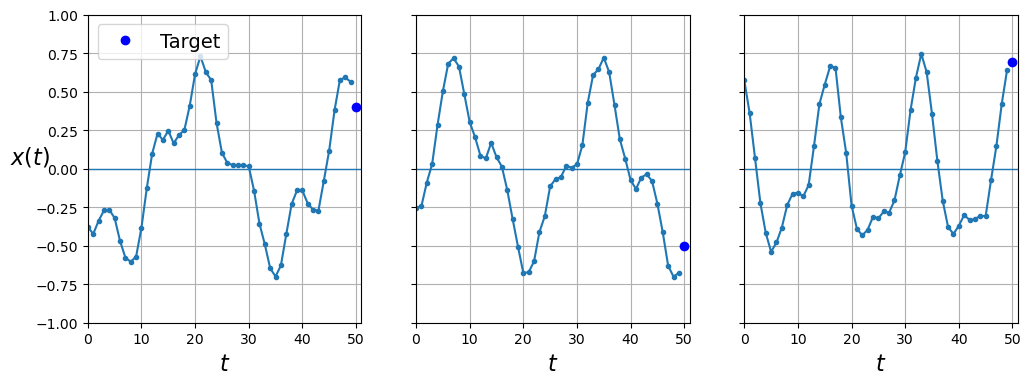

In [5]:
fig, axes = plt.subplots(1,3,sharey=True,figsize=(12,4))
for c in range(3):
    plt.sca(axes[c])
    plot_series(X_valid[c, :, 0], y_valid[c, 0],
                    y_label=("$x(t)$" if c==0 else None),
                    legend=( c == 0))

### Baseline

In [6]:
y_pred = X_valid[:,-1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

2023-09-28 14:39:07.712952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-28 14:39:07.738731: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-28 14:39:07.738800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-28 14:39:07.739677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

0.020211367

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])

In [8]:
# model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
# model.fit(X_train, y_train, epochs=20)

In [9]:
# model.evaluate(X_valid, y_valid)

### Simple RNN

In [10]:
s_model = keras.models.Sequential()
s_model.add(keras.layers.SimpleRNN(1, input_shape=[None, 1]))

In [11]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
s_model.compile(loss="mse", optimizer=optimizer)
# s_model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

In [12]:
s_model.layers[0].variables

[<tf.Variable 'simple_rnn/simple_rnn_cell/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-1.6165981]], dtype=float32)>,
 <tf.Variable 'simple_rnn/simple_rnn_cell/recurrent_kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-1.]], dtype=float32)>,
 <tf.Variable 'simple_rnn/simple_rnn_cell/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### Deep RNN

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

d_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

d_model.compile(loss="mse", optimizer="adam")
history = d_model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


2023-09-28 14:39:11.070473: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f1ef004af40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-28 14:39:11.070548: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2023-09-28 14:39:11.090158: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-28 14:39:11.364625: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 [==============================] - 48s 207ms/step - loss: 0.0161 - val_loss: 0.0048
Epoch 2/20
219/219 [==============================] - 45s 204ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 45s 204ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 45s 207ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 45s 206ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 46s 208ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 45s 207ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 8/20
219/219 [==============================] - 45s 207ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 45s 207ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 45s 204ms/step - loss: 0.0029

In [14]:
d_model.compile(loss="mse", optimizer="adam")
d_model.fit(X_train,y_train, epochs=20, validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 50s 219ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 2/20
219/219 [==============================] - 47s 214ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 3/20
219/219 [==============================] - 47s 213ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 4/20
219/219 [==============================] - 47s 216ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 5/20
219/219 [==============================] - 47s 215ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 6/20
219/219 [==============================] - 47s 217ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/20
219/219 [==============================] - 47s 212ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 47s 214ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/20
219/219 [==============================] - 47s 214ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/20
219/219 [==============================] - 47s 214ms/step - l

In [15]:
d_model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 22ms/step - loss: 0.0025


0.0024908219929784536

In [16]:
d_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [17]:
d_model.layers[2].output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'simple_rnn_3')>

### Forecasting Several Time Steps Ahead

In [18]:
series = generate_time_series(1, n_steps + 10)
X_new, y_new = series[:,:n_steps], series[:,n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = d_model.predict(X[:, step_ahead:])[:, np.newaxis,:]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred = X[:,n_steps:]
y_pred[0,:,0]

1/1 [==============================] - 0s 31ms/step


array([ 0.49930948,  0.3745125 ,  0.26703152,  0.2041196 ,  0.14632544,
        0.11146688,  0.06020035, -0.02863771, -0.13778263, -0.26780745],
      dtype=float32)

In [19]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [20]:
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 11):
    Y[:,:,step_ahead - 1] = series[:,step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [21]:
X_train.shape, Y_train.shape
X_valid.shape, Y_valid.shape

((2000, 50, 1), (2000, 50, 10))

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [23]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [24]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 39s 170ms/step - loss: 0.0561 - last_time_step_mse: 0.0465 - val_loss: 0.0420 - val_last_time_step_mse: 0.0298
Epoch 2/20
219/219 [==============================] - 37s 168ms/step - loss: 0.0420 - last_time_step_mse: 0.0306 - val_loss: 0.0407 - val_last_time_step_mse: 0.0291
Epoch 3/20
219/219 [==============================] - 33s 153ms/step - loss: 0.0375 - last_time_step_mse: 0.0266 - val_loss: 0.0342 - val_last_time_step_mse: 0.0228
Epoch 4/20
219/219 [==============================] - 34s 155ms/step - loss: 0.0319 - last_time_step_mse: 0.0203 - val_loss: 0.0291 - val_last_time_step_mse: 0.0172
Epoch 5/20
219/219 [==============================] - 34s 153ms/step - loss: 0.0296 - last_time_step_mse: 0.0177 - val_loss: 0.0281 - val_last_time_step_mse: 0.0155
Epoch 6/20
219/219 [==============================] - 33s 153ms/step - loss: 0.0275 - last_time_step_mse: 0.0152 - val_loss: 0.0287 - val_last_time_step_mse: 0.0175
Epoch 7/20

In [25]:
# model.predict(X_train)

### Deep RNNs with Layer Norm

In [26]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [27]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


2023-09-28 15:22:03.142929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600


219/219 [==============================] - 93s 407ms/step - loss: 0.1534 - last_time_step_mse: 0.1304 - val_loss: 0.0680 - val_last_time_step_mse: 0.0566
Epoch 2/20
219/219 [==============================] - 89s 405ms/step - loss: 0.0600 - last_time_step_mse: 0.0486 - val_loss: 0.0542 - val_last_time_step_mse: 0.0423
Epoch 3/20
219/219 [==============================] - 88s 404ms/step - loss: 0.0517 - last_time_step_mse: 0.0396 - val_loss: 0.0490 - val_last_time_step_mse: 0.0364
Epoch 4/20
219/219 [==============================] - 89s 406ms/step - loss: 0.0467 - last_time_step_mse: 0.0343 - val_loss: 0.0450 - val_last_time_step_mse: 0.0326
Epoch 5/20
219/219 [==============================] - 90s 409ms/step - loss: 0.0432 - last_time_step_mse: 0.0309 - val_loss: 0.0417 - val_last_time_step_mse: 0.0291
Epoch 6/20
146/219 [===================>..........] - ETA: 28s - loss: 0.0409 - last_time_step_mse: 0.0282

### LSTM

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
for rate in (1,2,4,8) * 2:
    print(rate)

### seq2seq

In [2]:
# encoder_input = keras.layers.Input(shape=[None], dtype=np.int32)
# decoder_input = keras.layers.Input(shape=[None], dtype=np.int32)
# sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

# embedding = keras.layers.Embedding(vocab_size, embed_size)
# encoder_embedding = embedding(encoder_input)
# decoder_embedding = embedding(decoder_input)

# encoder = keras.layers.LSTM(512, return_state=True)
# encoder_output, hidden_state, cell_state = encoder(encoder_embedding)
# encoder_state = [hidden_state, cell_state]

# sampler = tfa.seq2seq.sampler.TrainingSampler()

# decoder_cell = keras.layers.LSTMCell(512)
# output_layer = keras.layers.Dense(vocab_size)

# decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler, output_layer=output_layer)

# final_outputs, final_state, final_sequence_lengths  = decoder(decoder_embedding, initial_state=encoder_state, sequence_length=sequence_lengths)
# Y_proba = tf.nn.softmax(final_outputs.rnn_output)
# model = keras.Model(inputs=[encoder_input, decoder_input, sequence_lengths],outputs=[Y_proba])

### Bidirectonal RNNs

In [ ]:
keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))

### Beam Search

In [ ]:
beam_width = 10
decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(
    cell=decoder_cell, beam_width=beam_width, output_layer=output_layer
)
decoder_initial_state = tfa.seq2seq.beam_search_decoder.tile_batch(
    encoder_state, multiplier=beam_width
)
outputs, _, _ = decoder(
    embedding_decoder, start_tokens=start_tokens, end_token=end_token, initial_state=decoder_initial_state
)

### Attention mechanism